##### 본 매뉴얼은 베이지안 선형회귀모형 추정에 대해 다룬다.

# 베이지안 회귀분석
- 작성자: 고려대학교 경제학과 강규호 교수, 데이터사이언스팀 이창훈 과장

## 베이지안 선형회귀모형
### 모형
- $\sigma^{2} \sim IG(\frac{\alpha_{0}}{2}, \frac{\delta_{0}}{2})$
- $\beta \sim Normal(\beta_{0}, B_{0})$
- $Y|\beta, \sigma^{2} \sim Normal(X\beta, \sigma^{2}I_{T})$

### 사전분포에 대한 기본 하이퍼-파라미터
* 샘플링 크기
    * $n$: 깁스-샘플링 크기
    * $n_{0}$: 번인(burn-in) 크기
    * $n_{1}=n-n_{0}$: 사후분포 추론에 사용할 샘플링 크기
* $\beta$ 관련 하이퍼-파라미터 디폴트값
    * $\beta_{0}=0$
    * $B_{0}=25$
* $\sigma^{2}$ 관련 하이퍼-파라미터 디폴트값
    * $\alpha_{0}=5$
    * $\delta_{0}=5$

`bok_da` 라이브러리의 `bayes` 패키지, `linear_model` 모듈의 `gen_hyper_para` 함수를 이용해 선형모형에 대한 하이퍼 파라미터를 설정할 수 있다. 아무런 input을 넣지 않는 경우 디폴트 값으로 설정된다.

In [1]:
from bok_da.bayes.linear_model import gen_hyper_para

In [2]:
hyper = gen_hyper_para()
print(hyper)

{'n': 11000, 'n0': 1000, 'n1': 10000, 'beta0_': 0, 'B0_': 25, 'alpha0': 5, 'delta0': 5, 'sig2': 1.0}


사전분포의 하이퍼-파라미터를 변경하고 싶은 경우, 아래 예시에 따라 조정할 수 있다.

In [3]:
# 예1) sig2 의 하이퍼 파라미터 변경 시
hyper['alpha0'] = 10
hyper['delta0'] = 10
hyper['sig2'] = hyper['alpha0']/hyper['delta0'] # 사전 평균도 다시 계산해야 한다.

# 예2) 깁스-샘플링 크기 변경 시
hyper['n1'] = 20000
hyper['n0'] = int(hyper['n1'] * 0.1) # int 는 오류 방지를 위해 붙일 것을 권장한다.
hyper['n'] = hyper['n0'] + hyper['n1']

print(hyper)

{'n': 22000, 'n0': 2000, 'n1': 20000, 'beta0_': 0, 'B0_': 25, 'alpha0': 10, 'delta0': 10, 'sig2': 1.0}


### 선형회귀모형의 베이지안 추정 예제

* 데이터: 한국 GDP, CPI, M2, 국고채 10년, 미국 10년물 금리

### 1) 자료 불러오기

In [4]:
import pandas as pd

In [5]:
# 데이터프레임 형태로 데이터 불러오기
df = pd.read_excel("../data/bayes_test_data.xlsx") # test_data 폴더에서 엑셀파일 불러오기
df.columns = ['gdp', 'gdp_l1', 'cpi', 'm2', 'kr10y', 'us10y'] # 데이터 변수 이름 설정하기
df.index = pd.date_range(start='2000-Q4', end='2023-Q4', freq='Q') # 데이터 인덱스(날짜) 설정하기
df

,gdp,gdp_l1,cpi,m2,kr10y,us10y
2000-12-31,-0.324985,2.717335,0.659799,1.417791,7.760,5.12
2001-03-31,1.218106,-0.324985,1.766167,1.752773,6.690,4.93
2001-06-30,1.290518,1.218106,1.157815,2.339417,7.490,5.42
2001-09-30,1.341160,1.290518,0.574675,4.178410,6.440,4.60
2001-12-31,1.747232,1.341160,-0.254330,-0.487594,6.810,5.07
...,...,...,...,...,...,...
2022-09-30,0.233454,0.747667,1.128388,0.938318,3.497,3.83
2022-12-31,-0.303428,0.233454,0.394695,0.276973,3.890,3.88
2023-03-31,0.329332,-0.303428,1.047989,0.496197,3.437,3.48
2023-06-30,0.606808,0.329332,0.641578,0.824358,3.447,3.81


### 2) 모형 추정

In [6]:
# 베이지안 선형회귀 하이퍼 파라미터 생성
hyper = gen_hyper_para()

`bok_da` 라이브러리 `bayes` 패키지의 `linear_model` 서브패키지에서 베이지안 선형회귀모형 추정을 위한 깁스샘플링 함수 `bayes_linear`를 불러온다

In [7]:
from bok_da.bayes.linear_model import bayes_linear

In [8]:
# 종속변수와 설명변수 설정
Y = df['gdp'] # 종속변수 설정
X = df.drop(columns='gdp') # gdp를 제외한 나머지 변수를 설명변수로 설정

# gibbs_line 함수를 이용한 추정
res = bayes_linear(Y=Y, X=X, hyper=hyper, print_info=False)

In [9]:
res.beta

,gdp_l1,cpi,m2,kr10y,us10y
0,0.119053,0.628187,0.012301,0.033996,0.052528
1,0.032816,0.411609,0.137268,-0.141976,0.251670
2,0.159193,0.370437,0.092008,-0.136505,0.305635
3,0.148986,0.032587,0.074569,-0.159448,0.404809
4,0.053859,-0.059151,0.181778,-0.217320,0.422246
...,...,...,...,...,...
9994,0.097011,0.429700,0.040364,-0.023274,0.169755
9995,-0.083003,0.598927,0.056235,-0.215249,0.381303
9996,0.217405,0.284199,0.008574,0.029131,0.127910
9997,0.193500,0.254272,0.062887,-0.115696,0.312693


`bok_da` 라이브러리 `bayes` 패키지의 `linear_model` 서브패키지에서 `get_table` 함수를 불러와 결과를 출력한다.

In [10]:
from bok_da.bayes.linear_model import get_table

In [11]:
# 동일 추정에서 CI만 다르게 보고 싶은 경우 아래처럼 표만 따로 출력하는 것도 가능하다
# 또한 결과는 dataframe 형태로 저장되며 excel 형태로 밖으로 내보낼 수 있다.

tab_beta = get_table(res.beta, [0.025, 0.975], print_info=False)
tab_beta

,Mean,Median,S.E.,0.025%,0.975%
gdp_l1,0.107089,0.107094,0.108283,-0.100701,0.319983
cpi,0.293697,0.297118,0.181708,-0.071603,0.640418
m2,0.043230,0.042233,0.080788,-0.112593,0.202883
kr10y,-0.090755,-0.090981,0.110451,-0.308433,0.125585
us10y,0.272738,0.273381,0.136263,0.007654,0.540811


In [12]:
tab_r2 = get_table(res.r2, [0.025, 0.975], print_info=False)
tab_r2

,Mean,Median,S.E.,0.025%,0.975%
R2,0.378225,0.37773,0.035267,0.310825,0.447902


res 인스턴스의 get_table 메서드를 이용해서도 출력할 수 있다.

In [13]:
res.get_table('beta') # 문자열(str)로 출력하고자 하는 파라미터의 인자를 입력한다.

,Mean,Median,S.E.,0.05%,0.95%
gdp_l1,0.107089,0.107094,0.108283,-0.069098,0.287606
cpi,0.293697,0.297118,0.181708,-0.009247,0.587486
m2,0.043230,0.042233,0.080788,-0.085993,0.179323
kr10y,-0.090755,-0.090981,0.110451,-0.273878,0.091471
us10y,0.272738,0.273381,0.136263,0.049661,0.498582


In [14]:
res.get_table('r2')

,Mean,Median,S.E.,0.05%,0.95%
R2,0.378225,0.37773,0.035267,0.321252,0.436772


### 3) 예측분포 함께 출력

Out-of-sample forecasting(표본 외 예측)을 원할 경우 X의 실현값(XT1)을 함께 입력하면 yf(예측 분포)가 함께 출력된다.

In [15]:
res = bayes_linear(Y=Y.iloc[:-1], X=X.iloc[:-1,:], XT1=X.iloc[-1,:], hyper=hyper, print_info=True)

Coefficients: 
            Mean    Median      S.E.     0.05%     0.95%
gdp_l1  0.107201  0.107146  0.107875 -0.067359  0.284027
cpi     0.306878  0.307208  0.182672  0.004219  0.606501
m2      0.036123  0.035774  0.082223 -0.098992  0.172036
kr10y  -0.107884 -0.108271  0.113447 -0.294225  0.077333
us10y   0.298712  0.297748  0.143467  0.064479  0.536983
R2: 
        Mean    Median      S.E.     0.05%   0.95%
R2  0.380219  0.379395  0.035972  0.321607  0.4391
Forecast: 
        Mean    Median      S.E.     0.05%     0.95%
yf  1.362914  1.354666  0.936744 -0.170039  2.916245


In [16]:
get_table(res.yf, [0.05, 0.95], print_info=False)

,Mean,Median,S.E.,0.05%,0.95%
yf,1.362914,1.354666,0.936744,-0.170039,2.916245


### 4) PPL(Posterior Predictive Likelihood) 함께 출력

Out-of-sample Forecasting(표본 외 예측)을 통해 튜닝을 원할 경우 아래와 같이 X, Y의 실현값(XT1, YT1)을 모두 입력하면 log PPL이 함께 계산된다.

In [17]:
res = bayes_linear(Y=Y.iloc[:-1], X=X.iloc[:-1,:], YT1=Y.iloc[[-1]], XT1=X.iloc[-1,:], hyper=hyper, print_info=True)

Coefficients: 
            Mean    Median      S.E.     0.05%     0.95%
gdp_l1  0.106304  0.105722  0.107277 -0.068711  0.280653
cpi     0.306691  0.307843  0.184372  0.002449  0.606176
m2      0.037353  0.036345  0.082733 -0.097473  0.176071
kr10y  -0.108345 -0.107976  0.115582 -0.298131  0.080702
us10y   0.299172  0.298609  0.145408  0.060419  0.538283
R2: 
        Mean    Median      S.E.     0.05%     0.95%
R2  0.380654  0.380187  0.036022  0.322004  0.440274
Forecast: 
        Mean    Median      S.E.     0.05%     0.95%
yf  1.360052  1.361593  0.940206 -0.194094  2.911338
log PPL:  -1.170971149996178


- 결과 인스턴스에 포함되어있는 결과값 확인하기

In [18]:
list(res.__dict__.keys())

['beta', 'sig2', 'r2', 'yf', 'lnppl']

또는 res. + Tab으로 확인할 수 있다.

- 파라미터 추정결과 사후분포 그리기

In [19]:
from bok_da.bayes.linear_model import plot_hist

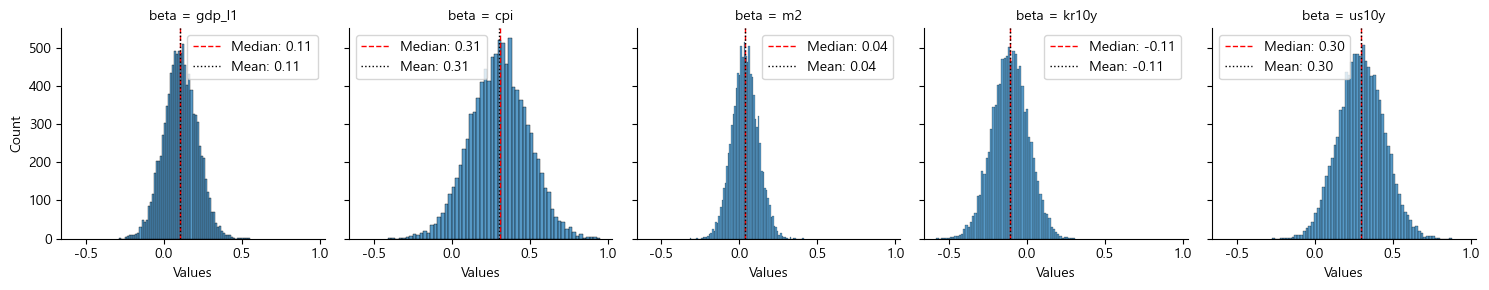

In [20]:
# beta 계수 히스토그램
plot_hist(res.beta, name='beta')

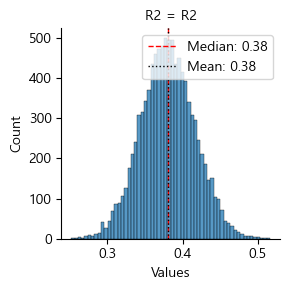

In [21]:
# R2 히스토그램
plot_hist(res.r2, name='R2')

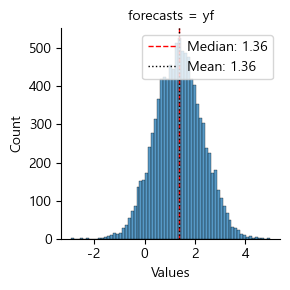

In [22]:
# 예측결과 히스토그램
plot_hist(res.yf, name='forecasts')

또는 res 인스턴스의 plot_hist 메서드를 이용해 바로 분포를 그릴 수 있다.

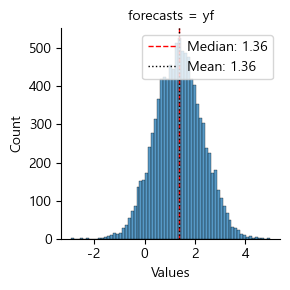

In [23]:
# 메서드 사용해서 히스토그램 그리기
res.plot_hist('yf')

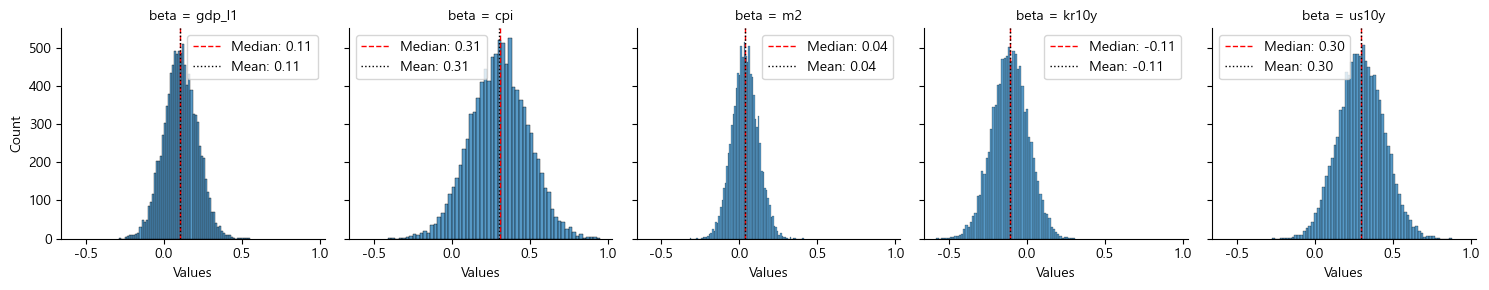

In [24]:
res.plot_hist('beta')

## BayesLinearRegression 클래스로 모형 설정하고 추정하기

`bayes_linear` 함수를 사용하는 방법외에 `BayesLinearRegression` 클래스를 이용한 추정 기능도 제공한다.

모형 클래스 불러오기
- `bok_da` 라이브러리 `bayes` 패키안의 `linear_model` 서브패키지에서 `BayesLinearRegression` 클래스를 불러온다.

In [25]:
from bok_da.bayes.linear_model import BayesLinearRegression

모형 설정
- BLR 클래스를 이용해 model 객체를 생성한다. 여기서 model의 특성은 hyper에 의해 결정된다.

In [26]:
hyper = gen_hyper_para()
model = BayesLinearRegression(hyper)

모형 추정
- model 인스턴스의 fit 메서드를 이용해 추정할 수 있다.

In [27]:
res = model.fit(df)

결과 보기
- res 인스턴스에 대해서 위의 예와 동일하게 get_table, plot_hist 등의 메서드를 적용할 수 있다.

In [28]:
res.get_table('beta', quantile=[0.05, 0.95])

,Mean,Median,S.E.,0.05%,0.95%
gdp_l1,0.108609,0.107766,0.106073,-0.064206,0.281272
cpi,0.291345,0.292864,0.182938,-0.007826,0.590260
m2,0.043803,0.043290,0.081919,-0.090740,0.178483
kr10y,-0.088295,-0.088463,0.111899,-0.276011,0.095272
us10y,0.269098,0.269677,0.137462,0.042095,0.497947


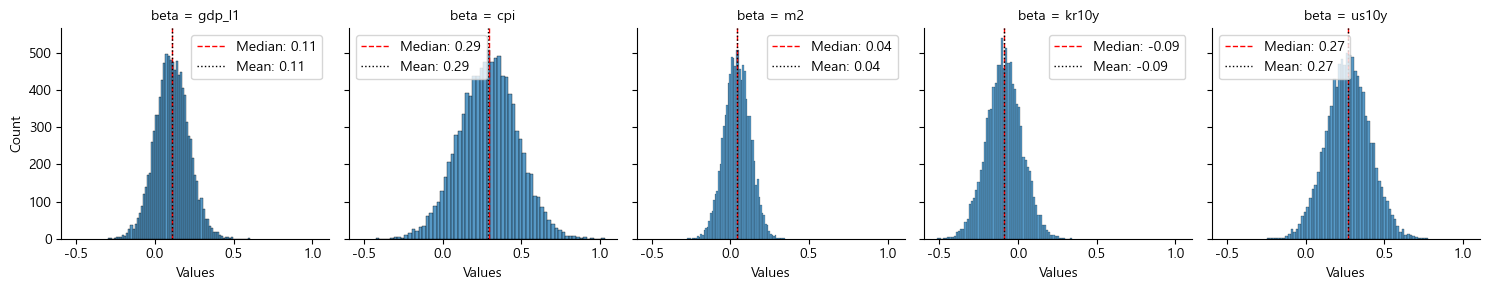

In [29]:
res.plot_hist('beta')

마지막 시점 예측: 예측분포와 log PPD(Posterior Predictive Density) 출력
- 예측대상 시점인 oos를 인자로 입력하고, model 인스턴스의 predict 메서드를 이용해서 예측할 수 있다.

In [30]:
oos = df.iloc[[-1]] # out-of-sample, data의 마지막행 전체열
res = model.predict(df, oos, print_info=True)

Coefficients: 
            Mean    Median      S.E.     0.05%     0.95%
gdp_l1  0.108366  0.108625  0.107929 -0.066369  0.284928
cpi     0.292650  0.292068  0.186147 -0.012225  0.599282
m2      0.043530  0.044011  0.080936 -0.091351  0.175531
kr10y  -0.088011 -0.089497  0.111596 -0.269773  0.094454
us10y   0.269180  0.271633  0.138601  0.042471  0.492151
R2: 
       Mean    Median     S.E.     0.05%     0.95%
R2  0.37843  0.377867  0.03582  0.320685  0.438212
Forecast: 
       Mean   Median      S.E.     0.05%     0.95%
yf  1.29145  1.29968  0.926862 -0.241734  2.804644
log PPL:  -1.1124778486185947
